<a href="https://colab.research.google.com/github/RyosukeHanaoka/TechTeacher/blob/main/swin_crp0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install vit_pytorch timm
from __future__ import print_function

import glob
import os
import random
import cv2
import shutil
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from vit_pytorch.efficient import ViT
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint

def split_and_move_files(src_dir, train_dest, val_dest, test_dest, split_ratio=(0.7, 0.2, 0.1)):
    all_files = glob.glob(f"{src_dir}/*")
    random.shuffle(all_files)

    train_split = int(split_ratio[0] * len(all_files))
    val_split = train_split + int(split_ratio[1] * len(all_files))

    for idx, file in enumerate(all_files):
        if idx < train_split:
            dest = train_dest
        elif idx < val_split:
            dest = val_dest
        else:
            dest = test_dest
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, os.path.join(dest, os.path.basename(file)))

src_dir_RA = '/content/drive/MyDrive/crp>0.3/image_crp0.3_patient'
train_dest_RA = '/content/train/RA_Right_Hand'
val_dest_RA = '/content/val/RA_Right_Hand'
test_dest_RA = '/content/test/RA_Right_Hand'

split_and_move_files(src_dir_RA, train_dest_RA, val_dest_RA, test_dest_RA)

src_dir_nonRA = '/content/drive/MyDrive/images_ra_and_nonra/image_nonra_patient'
train_dest_nonRA = '/content/train/nonRA_Right_Hand'
val_dest_nonRA = '/content/val/nonRA_Right_Hand'
test_dest_nonRA = '/content/test/nonRA_Right_Hand'

split_and_move_files(src_dir_nonRA, train_dest_nonRA, val_dest_nonRA, test_dest_nonRA)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 5.9 MB/s eta 0:00:00


In [11]:
batch_size=64
epochs = 50
lr = 0.3*1e-3
gamma = 0.8
seed = 42#乱数のシード。慣用的に42が使用されることが多い。
def seed_everything(seed):#使用するモジュールにおける乱数のシードを統一し、再現性を確保している。
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)#その他さまざまなtorchに含まれる非決定的な計算過程を決定的なものにして再現性を確保している
# GPUの設定
device = 'cuda'

from torchvision import transforms

# 前処理の定義
train_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),
    # transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    #transforms.RandomHorizontalFlip(),
    # transforms.RandomGrayscale(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError

# 画像のパス
train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/test"

class RobustImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(RobustImageFolder, self).__getitem__(index)
        except UnidentifiedImageError:
            print(f"Couldn't read image at index {index}: UnidentifiedImageError")
            # 代わりの画像を返す
            img = Image.new('RGB', (224, 224), color = 'gray')
            img = self.transform(img)
            target = 0  # または適切なクラスのインデックス
            return img, target

# データセットの定義
train_dataset = RobustImageFolder(train_dir, transform=train_transforms)
valid_dataset = RobustImageFolder(val_dir, transform=val_transforms)
test_dataset = RobustImageFolder(test_dir, transform=test_transforms)

# データローダーの設定を最適化
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size // 4,  # 実際のバッチサイズを小さくする
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size // 4,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size // 4,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

model_names = timm.list_models(pretrained=True)
#pprint(model_names)
#model = timm.create_model('resnet50.tv_in1k', pretrained=True, num_classes=2)
#model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)
model = timm.create_model('swin_base_patch4_window7_224.ms_in1k', pretrained = True, num_classes=2)

# modelをGPUで動作させる
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")
# loss function
criterion = nn.CrossEntropyLoss()#正常と異常の２値分類であるためクロスエントロピー法を用いる。
# criterion = nn.HuberLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)#パラメーターはデフォルト値を使用する。学習率は上記に定めたものを使用
# scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=gamma)

学習ループを設定し、実行していく

In [12]:
import gc
from torchvision.utils import make_grid

# メモリ最適化の環境変数設定
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = ':'.join([
    'max_split_size_mb:128',
    'expandable_segments:True'
])

def train_with_gradient_accumulation(model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    accumulation_steps = 4
    effective_batch_size = batch_size
    actual_batch_size = effective_batch_size // accumulation_steps

    train_acc_list = []
    val_acc_list = []
    test_acc_list = []
    train_loss_list = []
    val_loss_list = []
    test_loss_list = []

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(epochs):
        # 訓練フェーズ
        model.train()
        epoch_loss = 0
        epoch_accuracy = 0
        optimizer.zero_grad()

        for i, (data, label) in enumerate(tqdm(train_loader)):
            with torch.cuda.amp.autocast():
                data = data.to(device)
                label = label.to(device)

                output = model(data)
                loss = criterion(output, label)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss * accumulation_steps / len(train_loader)

            del data, label, output, loss
            if (i + 1) % (accumulation_steps * 2) == 0:
                torch.cuda.empty_cache()

        # 検証フェーズ
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

                del data, label, val_output, val_loss

            # テストフェーズ
            epoch_test_accuracy = 0
            epoch_test_loss = 0
            for data, label in tqdm(test_loader):
                data = data.to(device)
                label = label.to(device)

                test_output = model(data)
                test_loss = criterion(test_output, label)

                acc = (test_output.argmax(dim=1) == label).float().mean()
                epoch_test_accuracy += acc / len(test_loader)
                epoch_test_loss += test_loss / len(test_loader)

                del data, label, test_output, test_loss

            torch.cuda.empty_cache()

        # 結果の記録
        train_acc_list.append(epoch_accuracy)
        val_acc_list.append(epoch_val_accuracy)
        test_acc_list.append(epoch_test_accuracy)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(epoch_val_loss)
        test_loss_list.append(epoch_test_loss)

        print(
            f"Epoch : {epoch+1} - "
            f"loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - "
            f"val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} - "
            f"test_loss : {epoch_test_loss:.4f} - test_acc: {epoch_test_accuracy:.4f}\n"
        )

        scheduler.step()

    return train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list
# モデルの設定を最適化
def optimize_model_settings():
    # メモリ関連の設定を最適化
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True

    # モデルの設定を最適化
    model.to(device)
    if hasattr(model, 'transformer'):
        for block in model.transformer.blocks:
            block.attn.fused_attn = True

    return model
# main関数も更新
def main():
    model = optimize_model_settings()
    train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list = train_with_gradient_accumulation(
        model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs
    )
    return model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list

# 実行
model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list = main()

<ipython-input-12-f9a2aeb43fb6>:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/12 [00:00<?, ?it/s]

<ipython-input-12-f9a2aeb43fb6>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.7947 - acc: 0.4896 - val_loss : 0.6302 - val_acc: 0.6719 - test_loss : 0.6681 - test_acc: 0.6250



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6707 - acc: 0.5990 - val_loss : 0.6093 - val_acc: 0.6719 - test_loss : 0.6308 - test_acc: 0.6250



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6550 - acc: 0.6094 - val_loss : 0.6151 - val_acc: 0.7865 - test_loss : 0.6196 - test_acc: 0.7723



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6071 - acc: 0.7240 - val_loss : 0.5082 - val_acc: 0.7552 - test_loss : 0.5450 - test_acc: 0.7411



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.5897 - acc: 0.7135 - val_loss : 0.4574 - val_acc: 0.7708 - test_loss : 0.5041 - test_acc: 0.7411



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.5124 - acc: 0.7135 - val_loss : 0.4827 - val_acc: 0.8021 - test_loss : 0.5271 - test_acc: 0.7723



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.9178 - acc: 0.6198 - val_loss : 0.5534 - val_acc: 0.7031 - test_loss : 0.5931 - test_acc: 0.6518



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6733 - acc: 0.6458 - val_loss : 0.6200 - val_acc: 0.8333 - test_loss : 0.6567 - test_acc: 0.7366



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6319 - acc: 0.6510 - val_loss : 0.5081 - val_acc: 0.8021 - test_loss : 0.5505 - test_acc: 0.7098



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.5980 - acc: 0.6667 - val_loss : 0.5192 - val_acc: 0.8021 - test_loss : 0.5396 - test_acc: 0.7098



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.5688 - acc: 0.7344 - val_loss : 0.5205 - val_acc: 0.8021 - test_loss : 0.5318 - test_acc: 0.7723



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.5663 - acc: 0.7344 - val_loss : 0.4548 - val_acc: 0.8177 - test_loss : 0.4798 - test_acc: 0.7723



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.5469 - acc: 0.7292 - val_loss : 0.5670 - val_acc: 0.6823 - test_loss : 0.5559 - test_acc: 0.7321



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.5778 - acc: 0.6562 - val_loss : 0.4271 - val_acc: 0.8177 - test_loss : 0.4370 - test_acc: 0.8348



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.5227 - acc: 0.6823 - val_loss : 0.4859 - val_acc: 0.7708 - test_loss : 0.5003 - test_acc: 0.7723



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.4987 - acc: 0.7708 - val_loss : 0.3895 - val_acc: 0.8177 - test_loss : 0.4087 - test_acc: 0.8036



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.5057 - acc: 0.7344 - val_loss : 0.4471 - val_acc: 0.8021 - test_loss : 0.4660 - test_acc: 0.8036



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.4585 - acc: 0.7917 - val_loss : 0.3679 - val_acc: 0.8177 - test_loss : 0.3695 - test_acc: 0.8348



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5014 - acc: 0.7865 - val_loss : 0.4325 - val_acc: 0.7865 - test_loss : 0.4674 - test_acc: 0.8036



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.4561 - acc: 0.7708 - val_loss : 0.3618 - val_acc: 0.8646 - test_loss : 0.3990 - test_acc: 0.8036



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.5132 - acc: 0.7344 - val_loss : 0.3890 - val_acc: 0.8490 - test_loss : 0.4317 - test_acc: 0.8036



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.4188 - acc: 0.7969 - val_loss : 0.3544 - val_acc: 0.8438 - test_loss : 0.3599 - test_acc: 0.9018



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.4027 - acc: 0.8073 - val_loss : 0.3693 - val_acc: 0.8333 - test_loss : 0.3910 - test_acc: 0.8036



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.4432 - acc: 0.7865 - val_loss : 0.3356 - val_acc: 0.8594 - test_loss : 0.3485 - test_acc: 0.8705



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.4422 - acc: 0.8073 - val_loss : 0.3150 - val_acc: 0.8906 - test_loss : 0.3284 - test_acc: 0.9330



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.4187 - acc: 0.8177 - val_loss : 0.3224 - val_acc: 0.8906 - test_loss : 0.3589 - test_acc: 0.9330



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.4059 - acc: 0.8281 - val_loss : 0.4312 - val_acc: 0.8177 - test_loss : 0.5274 - test_acc: 0.8348



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.4279 - acc: 0.8438 - val_loss : 0.3179 - val_acc: 0.8646 - test_loss : 0.3918 - test_acc: 0.8348



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.3229 - acc: 0.8438 - val_loss : 0.3029 - val_acc: 0.8750 - test_loss : 0.3285 - test_acc: 0.9018



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.3692 - acc: 0.8490 - val_loss : 0.3661 - val_acc: 0.8906 - test_loss : 0.4864 - test_acc: 0.7679



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.3638 - acc: 0.8333 - val_loss : 0.2848 - val_acc: 0.8906 - test_loss : 0.3185 - test_acc: 0.9330



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.4278 - acc: 0.7917 - val_loss : 0.2716 - val_acc: 0.9062 - test_loss : 0.3258 - test_acc: 0.9018



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.3210 - acc: 0.8646 - val_loss : 0.3047 - val_acc: 0.9219 - test_loss : 0.4528 - test_acc: 0.8348



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.3254 - acc: 0.8646 - val_loss : 0.2678 - val_acc: 0.9219 - test_loss : 0.3403 - test_acc: 0.8705



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.3022 - acc: 0.9010 - val_loss : 0.5098 - val_acc: 0.7292 - test_loss : 0.6841 - test_acc: 0.6607



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.3815 - acc: 0.7865 - val_loss : 0.4731 - val_acc: 0.7812 - test_loss : 0.3303 - test_acc: 0.8393



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.3922 - acc: 0.8490 - val_loss : 0.3322 - val_acc: 0.8646 - test_loss : 0.4599 - test_acc: 0.8348



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.3169 - acc: 0.8646 - val_loss : 0.3263 - val_acc: 0.8438 - test_loss : 0.3434 - test_acc: 0.8705



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.3638 - acc: 0.8438 - val_loss : 0.2950 - val_acc: 0.9219 - test_loss : 0.4232 - test_acc: 0.8348



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.2782 - acc: 0.8958 - val_loss : 0.2550 - val_acc: 0.9219 - test_loss : 0.3258 - test_acc: 0.9330



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.2452 - acc: 0.9010 - val_loss : 0.2427 - val_acc: 0.9531 - test_loss : 0.3570 - test_acc: 0.9018



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.2141 - acc: 0.9167 - val_loss : 0.2171 - val_acc: 0.9062 - test_loss : 0.2345 - test_acc: 0.8705



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.3166 - acc: 0.8854 - val_loss : 0.2628 - val_acc: 0.9219 - test_loss : 0.4351 - test_acc: 0.9018



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.2173 - acc: 0.9115 - val_loss : 0.2685 - val_acc: 0.9219 - test_loss : 0.5148 - test_acc: 0.8705



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.2375 - acc: 0.9010 - val_loss : 0.2585 - val_acc: 0.9219 - test_loss : 0.3425 - test_acc: 0.9330



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.2397 - acc: 0.8802 - val_loss : 0.2585 - val_acc: 0.9219 - test_loss : 0.2071 - test_acc: 0.9062



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.2782 - acc: 0.8750 - val_loss : 0.4932 - val_acc: 0.7760 - test_loss : 0.5873 - test_acc: 0.6920



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.2962 - acc: 0.8698 - val_loss : 0.2479 - val_acc: 0.8594 - test_loss : 0.3177 - test_acc: 0.9018



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.2397 - acc: 0.9115 - val_loss : 0.2510 - val_acc: 0.9062 - test_loss : 0.3703 - test_acc: 0.8661



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.1766 - acc: 0.9427 - val_loss : 0.2446 - val_acc: 0.9062 - test_loss : 0.3260 - test_acc: 0.9330



# 学習結果の可視化

<ipython-input-13-a14de596ddeb>:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1,2,1)


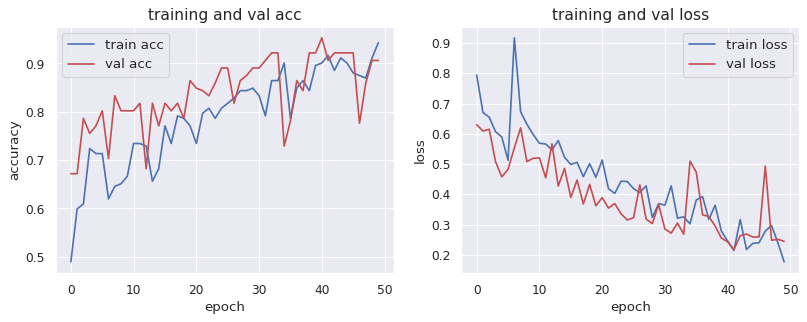

In [13]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)

    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)

    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)

    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

In [6]:
model_save_path = '/content/drive/MyDrive/ResNet50crp0.3_checkpoint'
torch.save(model.state_dict(), model_save_path)

In [14]:
class GradCam:
    def __init__(self, model, device):
        self.model = model
        self.feature = None
        self.gradient = None
        self.device = device

        def forward_hook(module, input, output):
            self.feature = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0].detach()

        # 最後のアテンションブロックを取得
        if hasattr(model, 'blocks'):
            target_layer = model.blocks[-1]
            target_layer.register_forward_hook(forward_hook)
            target_layer.register_full_backward_hook(backward_hook)
        else:
            raise ValueError("Unexpected model architecture")

    def __call__(self, x):
        self.feature = None
        self.gradient = None

        # 入力をデバイスに移動
        x = x.to(self.device)

        # 予測を実行
        output = self.model(x)
        pred_class = output.argmax(dim=1)

        # 予測クラスに対する勾配を計算
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, pred_class] = 1
        output.backward(gradient=one_hot)

        # 特徴量と勾配の処理
        feature_map = self.feature[:, 1:, :]  # CLSトークンを除外
        gradient_map = self.gradient[:, 1:, :]  # CLS トークンを除外

        # 重みの計算
        weights = gradient_map.mean(dim=2)  # [1, N]

        # CAMの計算
        batch_size = feature_map.shape[0]
        num_patches = feature_map.shape[1]
        patch_size = int(np.sqrt(num_patches))

        cam = torch.mul(feature_map, weights.unsqueeze(-1))
        cam = cam.mean(dim=2)  # [1, N]

        # パッチサイズに変形
        cam = cam.view(batch_size, patch_size, patch_size)

        # 正規化とReLU
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        # 元の画像サイズにリサイズ
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)

        return cam

def overlay_heatmap_to_image(image, heatmap):
    # 画像を[0, 255]の範囲に変換
    image = ((image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255).astype(np.uint8)

    # ヒートマップを[0, 255]の範囲に変換してカラーマップを適用
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    # 別のカラーマップを試す（例：COLORMAP_VIRIDISやCOLORMAP_INFERNO）
    #heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_INFERNO)

    # 画像とヒートマップを重ね合わせ
    alpha = 0.2
    overlayed = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)

    return overlayed / 255.0

# GradCAMのインスタンスを作成
grad_cam = GradCam(model, device)

# テストデータから画像を取得
images, labels = next(iter(test_loader))
images = images[:5]
labels = labels[:5]

# ヒートマップの生成と表示
plt.figure(figsize=(20, 4))

for i, (image, label) in enumerate(zip(images, labels)):
    try:
        # GradCAMを計算
        heatmap = grad_cam(image.unsqueeze(0))

        # ヒートマップをオーバーレイ
        overlayed = overlay_heatmap_to_image(image, heatmap)

        # 結果を表示
        plt.subplot(1, 5, i+1)
        plt.imshow(overlayed)
        plt.title(f'Class: {label.item()}')
        plt.axis('off')
    except Exception as e:
        print(f"Error processing image {i}: {str(e)}")

plt.title(f'Class: {"RA" if label.item() == 0 else "Non-RA"}')
plt.tight_layout()
plt.show()

# メモリの解放
torch.cuda.empty_cache()
gc.collect()

ValueError: Unexpected model architecture